## NEMOSIS and Pandas to replicate AEMO's analysis demonstrating the precision of battery dispatch

|![alt text](initial_operation_of_hpr_aemo_2018.PNG)|
|:--:|
|Initial operation of HPR (AEMO, 2018)|

This note book demonstrates how to use NEMOSIS and pandas to create a comparison 
of Hornsdale Power Reserves' actual ouput against it's AGC setpoint.

This done using the 4 second resolution FCAS causer pays data published by AEMO. This data includes SCADA readings of plant output and the FCAS regulation set points. The energy market dispatch set points are calculated from the dispatch interval initial outputs, dispatch targets for the end of the interval, and assumes a linear ramp. The net AGC set point is assumed to be the sum of regulation and energy market components. 

Before you get started:
* AEMO's nemweb portal, which NEMOSIS uses, only provides causer pays data for the previous 90 days. Also, the dispatch target data used is provided on a monthly basis, published sometime after the end of each month. This means care must be take in selecting a time period to analyse that has both data sets available.
* getting plotly (the graphing package I've used) working in a jupyter notebook takes a little bit of extra work but the process is well documented here: https://plotly.com/python/getting-started/

The end result should look like this:

|![alt text](agc_target_vs_scada.jpg)|
|:--:|
|Recreation for 2021/04/27 12:00:00 to 2021/04/27 13:00:00|

Interpreting the results, our analysis shows a larger discrepancy between the ouput and set point then the analysis published by AEMO. However, this may be due to difference in the analysis rather than in actual performance. A few things we haven't considered are lag in the AGC signal and the impact of the unit control model. This report by DigSilent for AEMO makes good further reading on the topic (https://www.aemo.com.au/-/media/Files/Stakeholder_Consultation/Working_Groups/Other_Meetings/ASTAG/371100-ETR1-Version-30-20170919-AEMO-Review-of-Frequency-Control.pdf)



In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from nemosis import static_table, dynamic_data_compiler
import plotly.express as px

In [2]:
# Specify where we will be caching the raw AEMO data.
raw_data_cache = 'C:/Users/nick/Desktop/cache'

In [4]:
# Time window to pull data from.
start_time = '2021/04/27 12:00:00'
end_time = '2021/04/27 13:00:00'

In [5]:
# Download the latest FCAS causer pays elements file. The 
# update_static_file=True argument forces nemosis to download a new copy of 
# file from AEMO even if a copy already exists in the cache.
fcas_elements = static_table(table_name='ELEMENTS_FCAS_4_SECOND', 
                             raw_data_location=raw_data_cache,
                             update_static_file=True)

Retrieving static table ELEMENTS_FCAS_4_SECOND.


In [6]:
# Using filtering and manual inspection find which fcas element numbers belong 
# to Hornsdale Power Reserve.
fcas_elements[fcas_elements['EMSNAME'].str.contains('HPR')]

,ELEMENTNUMBER,EMSNAME,ELEMENTTYPE,MMSDESCRIPTOR
248,330,SUBSTN.HRN_WF.GEN.HPRG1,GEN,*MMS MarketName*
249,331,SUBSTN.HRN_WF.LOAD.HPRL1,GEN,*MMS MarketName*


In [7]:
# Check which variables are needed. By comparing the contents of the 
# VARIABLES_FCAS_4_SECOND table and the information provided by AEMO here:
# https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/ancillary-services-data/ancillary-services-market-causer-pays-data
# we can suppose that variable 2 (Gen_MW) will provide generation and 
# consumption data and varaible 5 (GenRegComp_MW) is the amount of regulation 
# FCAS being requested.
static_table(table_name='VARIABLES_FCAS_4_SECOND', 
             raw_data_location=raw_data_cache, 
             update_static_file=True)

Retrieving static table VARIABLES_FCAS_4_SECOND.


,VARIABLENUMBER,VARIABLETYPE
0,1,MW
1,2,Gen_MW
2,3,GenSPD_MW
3,4,GenRPF_%
4,5,GenRegComp_MW
5,6,Spare06
6,7,Spare07
7,8,Spare08
8,9,ON
9,10,OFF


In [8]:
# With the elements and variables determined we can compile the required 4s
# scada data. The fformat parquet and keep_csv False is used to save disk space.
scada_4s_resolution = dynamic_data_compiler(
    start_time, end_time, table_name='FCAS_4_SECOND',
    raw_data_location=raw_data_cache, 
    filter_cols=['ELEMENTNUMBER', 'VARIABLENUMBER'],
    filter_values=([330, 331], [2, 5]), fformat='parquet',
    keep_csv=False)

Compiling data for table FCAS_4_SECOND.
Returning FCAS_4_SECOND.


In [9]:
scada_4s_resolution.head()

,TIMESTAMP,ELEMENTNUMBER,VARIABLENUMBER,VALUE,VALUEQUALITY
992,2021-04-27 12:55:03,330,2,0.0,0
995,2021-04-27 12:55:03,330,5,0.0,-1
996,2021-04-27 12:55:03,331,2,7.6,0
999,2021-04-27 12:55:03,331,5,0.0,-1
2512,2021-04-27 12:55:07,330,2,0.0,0


In [10]:
# The FCAS 4 s data does not provide the plant dispatch targets for the end of 
# dispatch peroid in a user friendly format, so this data will be sourced
# from the table DISPATCHLOAD.
targets_5min_resolution = dynamic_data_compiler(
    start_time, end_time, 'DISPATCHLOAD', raw_data_cache,
    select_columns=['SETTLEMENTDATE', 'DUID', 'INITIALMW','TOTALCLEARED'],
    filter_cols=['DUID'], filter_values=(['HPRG1', 'HPRL1'],))

Compiling data for table DISPATCHLOAD.
Returning DISPATCHLOAD.


In [11]:
targets_5min_resolution.head()

,SETTLEMENTDATE,DUID,INITIALMW,TOTALCLEARED
2704884,2021-04-27 12:05:00,HPRG1,0.0,0.0
2704885,2021-04-27 12:05:00,HPRL1,73.4,0.0
2705241,2021-04-27 12:10:00,HPRG1,0.0,0.0
2705242,2021-04-27 12:10:00,HPRL1,7.7,0.0
2705598,2021-04-27 12:15:00,HPRG1,2.6,0.0


In [12]:
# Add some more readable descriptors to the 4s data.
elements = {
    330: 'HPRG1',
    331: 'HPRL1'
}

variables = {
    2: 'Output MW',
    5: 'Regulation Component MW'
}

scada_4s_resolution['DUID'] = scada_4s_resolution['ELEMENTNUMBER'].apply(lambda x: elements[x])
scada_4s_resolution['variable'] = scada_4s_resolution['VARIABLENUMBER'].apply(lambda x: variables[x])

scada_4s_resolution.head()

,TIMESTAMP,ELEMENTNUMBER,VARIABLENUMBER,VALUE,VALUEQUALITY,DUID,variable
992,2021-04-27 12:55:03,330,2,0.0,0,HPRG1,Output MW
995,2021-04-27 12:55:03,330,5,0.0,-1,HPRG1,Regulation Component MW
996,2021-04-27 12:55:03,331,2,7.6,0,HPRL1,Output MW
999,2021-04-27 12:55:03,331,5,0.0,-1,HPRL1,Regulation Component MW
2512,2021-04-27 12:55:07,330,2,0.0,0,HPRG1,Output MW


In [13]:
# Resahpe the 4s data.
scada_4s_resolution = scada_4s_resolution.pivot(index=['TIMESTAMP', 'DUID'], columns='variable', values='VALUE')
scada_4s_resolution.reset_index(inplace=True)
scada_4s_resolution.head()

variable,TIMESTAMP,DUID,Output MW,Regulation Component MW
0,2021-04-27 12:00:03,HPRG1,0.0,0.0
1,2021-04-27 12:00:03,HPRL1,76.8,0.0
2,2021-04-27 12:00:07,HPRG1,0.0,0.0
3,2021-04-27 12:00:07,HPRL1,78.1,0.0
4,2021-04-27 12:00:11,HPRG1,0.0,0.0


In [14]:
# Merge the 4s and 5min data such that each 4s data point is paired with the
# initial output and dispatch target for the current dispatch interval.
scada = pd.merge_asof(scada_4s_resolution, targets_5min_resolution, 
                      left_on='TIMESTAMP', right_on='SETTLEMENTDATE', by='DUID', 
                      direction='forward')
scada.head()

,TIMESTAMP,DUID,Output MW,Regulation Component MW,SETTLEMENTDATE,INITIALMW,TOTALCLEARED
0,2021-04-27 12:00:03,HPRG1,0.0,0.0,2021-04-27 12:05:00,0.0,0.0
1,2021-04-27 12:00:03,HPRL1,76.8,0.0,2021-04-27 12:05:00,73.4,0.0
2,2021-04-27 12:00:07,HPRG1,0.0,0.0,2021-04-27 12:05:00,0.0,0.0
3,2021-04-27 12:00:07,HPRL1,78.1,0.0,2021-04-27 12:05:00,73.4,0.0
4,2021-04-27 12:00:11,HPRG1,0.0,0.0,2021-04-27 12:05:00,0.0,0.0


In [15]:
# Calculate the fraction of the linear ramp from the initial operating level
# to the dispatch target that the unit should have completed at a given 
# TIMESATMP.
scada['fraction_ramp_complete'] = (
    1 - ((scada['SETTLEMENTDATE'] - scada['TIMESTAMP']) / timedelta(minutes=5)))

In [16]:
# Calculate the dispatch target on a 4s basis based on a linear ramp between
# the initial operating level and the end of interval target.
scada['linear_ramp_target'] = (
    scada['INITIALMW'] + (scada['TOTALCLEARED'] - scada['INITIALMW']) * 
    scada['fraction_ramp_complete'])

In [17]:
# Adjust values to account for the fact HPRL1 is a load.
scada['linear_ramp_target'] = np.where(scada['DUID'] == 'HPRL1',  
                                       -1 * scada['linear_ramp_target'],
                                       scada['linear_ramp_target'])
scada['Output MW'] = np.where(scada['DUID'] == 'HPRL1',  
                                -1 * scada['Output MW'],
                                scada['Output MW'])
scada['Regulation Component MW'] = np.where(scada['DUID'] == 'HPRL1',  
                                      -1 * scada['Regulation Component MW'],
                                      scada['Regulation Component MW'])

In [18]:
# Combine generation and consumption data.
scada = scada.groupby('TIMESTAMP', as_index=False).agg(
    {'linear_ramp_target': 'sum', 'Output MW': 'sum', 
     'Regulation Component MW': 'sum'})

In [21]:
# Calculate the combined linear ramping and regulation target.
scada['AGC Setpoint'] = scada['linear_ramp_target'] + scada['Regulation Component MW']

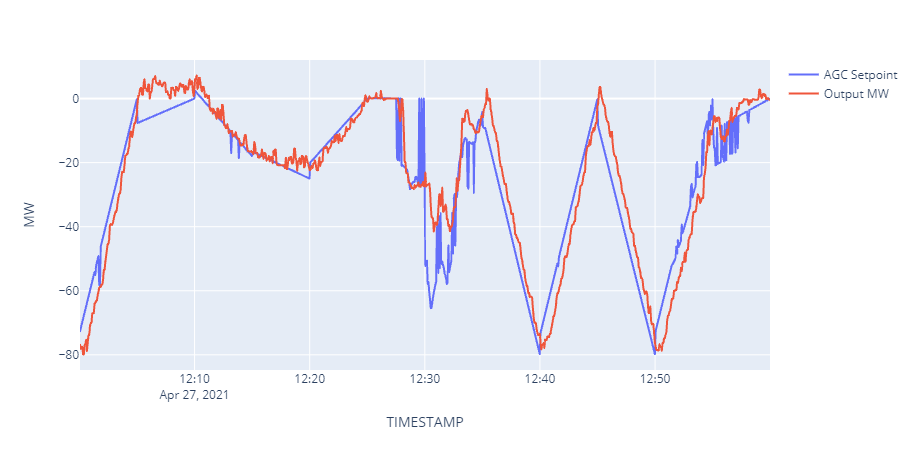

In [23]:
# Plot the results.
fig = px.line(scada, x='TIMESTAMP', y=['AGC Setpoint', 'Output MW'])
fig.update_layout(yaxis_title="MW", legend_title=None)
fig.show()